# 13장. 나이브 베이즈 (NaiveBayes)  과제

## 1. 데이터 읽기

### 1.1 SpamAssassin 데이터셋 다운 로드

In [1]:
from io import BytesIO
import requests
import tarfile
import os
from scratch.machine_learning import split_data

BASE_URL = "https://spamassassin.apache.org/old/publiccorpus/"
FILES = ["20021010_easy_ham.tar.bz2",
         "20021010_hard_ham.tar.bz2",
         "20021010_spam.tar.bz2"]
OUTPUT_DIR = 'spam_data'

if os.path.exists(OUTPUT_DIR) is False:
    for filename in FILES:
        content = requests.get(f"{BASE_URL}/{filename}").content

        fin = BytesIO(content)

        with tarfile.open(fileobj=fin, mode='r:bz2') as tf:
            tf.extractall(OUTPUT_DIR)

### 1.2 메세지 클래스 정의

In [2]:
from typing import NamedTuple

class Message(NamedTuple):
    text: str
    is_spam: bool

### 1.3 이메일 본문 디코딩

In [3]:
from email.parser import Parser

def decode_email(msg_str):
    p = Parser()
    message = p.parsestr(msg_str)
    decoded_message = ''
    for part in message.walk():
        if part.get_content_type() not in ('text/plain', 'text/html'): continue

        charset = part.get_content_charset()
        part_str = part.get_payload(decode=1)
        try:
            decoded_message += part_str.decode(charset)
        except:
            decoded_message += str(part_str)

    return decoded_message

### 1.3 이메일 텍스트 읽기 (Q)
이메일의 제목과 본문 텍스트를 읽어서 Message 타입을 만들고 데이터 리스트를 생성하시오.

In [4]:
import glob
import email
from typing import List
import re

def read_emails(include_body : bool = False) -> List[Message]:
    # modify the path to wherever you've put the files
    path = 'spam_data/*/*'

    data: List[Message] = []
    # glob.glob returns every filename that matches the wildcarded path
    for filename in glob.glob(path):
        is_spam = "ham" not in filename
        # is_spam = "spam" in filename
        # There are some garbage characters in the emails, the errors='ignore'
        # skips them instead of raising an exception.
        with open(filename, errors='ignore') as email_file:
            raw_email = email_file.read()
            msgobj = email.message_from_string(raw_email)
            message = msgobj['Subject'] or ""
            message = message.lower()
            message = message.replace("\n","")
            
            body = decode_email(raw_email)
            body1 = body.replace("\n","")
            bdoy2 = body1.strip('\n')
            # body = body.lower()
            result = message + body
            # data.append(Message(message, is_spam))
            
            # data.append(Message(body, is_spam))
            data.append(Message(result, is_spam))
            
           
    return data

In [5]:
include_body = True
data = read_emails(include_body= True)            
print("읽은 email 개수 :", len(data))

# print(type(data))
# print(data[30:35])

읽은 email 개수 : 3302


## 2. NLTK 설치 및 테스트  

### 2.1 NLTK설치 및 리소스 다운로드

In [6]:
! pip install nltk

In [7]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### 2.1 단어 토큰화 및 어간 추출 테스트

#### 단어 토큰화

In [8]:
from nltk.tokenize import TreebankWordTokenizer
text="This was not the map we found in Billy Bones's chest, but an accurate copy, complete in all things--names and heights and soundings--with the single exception of the red crosses and the written notes."
tokenizer=TreebankWordTokenizer()
words = tokenizer.tokenize(text)
print("tokens : ", words)

tokens :  ['This', 'was', 'not', 'the', 'map', 'we', 'found', 'in', 'Billy', "Bones's", 'chest', ',', 'but', 'an', 'accurate', 'copy', ',', 'complete', 'in', 'all', 'things', '--', 'names', 'and', 'heights', 'and', 'soundings', '--', 'with', 'the', 'single', 'exception', 'of', 'the', 'red', 'crosses', 'and', 'the', 'written', 'notes', '.']


#### 불용어

In [9]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))
print("stopwords : ", stopwords_set)

stopwords :  {'doing', 'after', 'are', "doesn't", 'was', 'most', 'being', 'i', 'by', 'out', 't', 'hasn', 'his', 'once', "you'd", 'between', 'such', 'which', 'm', "weren't", 'in', 'for', "don't", 'ours', 'those', 'y', "she's", 'll', 'isn', 'only', 'mightn', 'my', 'if', 'needn', 'through', 'shan', 'you', 'whom', "aren't", 'do', "haven't", 'each', 'too', 'nor', 'myself', 'from', 'then', 'him', 'what', 've', 'more', "mightn't", 'haven', 'ourselves', 'that', 'these', 'up', 'me', 'as', 'further', 'now', "that'll", 'didn', "you're", 'does', 'couldn', 'under', 'and', 'this', 'not', 'its', 'because', 'herself', 'same', 'than', 'have', 'an', 'ma', 'she', 'some', 'until', 'has', 'having', 'own', "needn't", 'be', 'before', 'am', 'he', 'other', "should've", 'above', 'the', "you'll", 'again', 'both', 'a', 'there', "won't", 'o', "shan't", 'yours', 'our', "hadn't", 'to', 'is', 's', 'about', 'so', "wasn't", 'their', "you've", 'but', 'wouldn', 'did', 'off', 'should', 'will', 'mustn', "wouldn't", 'when',

#### 어간 추출

In [10]:
from nltk.stem import PorterStemmer
s = PorterStemmer()
stem_words = [s.stem(w) for w in words]
print("stem tokens : ", len(stem_words), stem_words)
print("")
stem_words_wo_stopwords = [s.stem(w) for w in words if w not in stopwords_set]
print("stem tokens without stopwords: ", 
      len(stem_words_wo_stopwords),
      stem_words_wo_stopwords)

stem tokens :  41 ['thi', 'wa', 'not', 'the', 'map', 'we', 'found', 'in', 'billi', "bones'", 'chest', ',', 'but', 'an', 'accur', 'copi', ',', 'complet', 'in', 'all', 'thing', '--', 'name', 'and', 'height', 'and', 'sound', '--', 'with', 'the', 'singl', 'except', 'of', 'the', 'red', 'cross', 'and', 'the', 'written', 'note', '.']

stem tokens without stopwords:  24 ['thi', 'map', 'found', 'billi', "bones'", 'chest', ',', 'accur', 'copi', ',', 'complet', 'thing', '--', 'name', 'height', 'sound', '--', 'singl', 'except', 'red', 'cross', 'written', 'note', '.']


### 2.3 토큰화 함수 (Q)
Treebank Tokenizer를 사용해서 어간 추출 및 불용어 제거를 해보자.

In [11]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from typing import Set

def tokenize(text: str) -> Set[str]:
    tokenizer=TreebankWordTokenizer()
    text = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    result = []
    for w in text:
        w = w.lower()
        if w not in stop_words:
            if len(w) > 2:
                result.append(w)
    s = PorterStemmer()
    resultword = [s.stem(w) for w in result if w not in stopwords_set]
    words = resultword
    
    return set(words)                       # remove duplicates.
print(len(tokenize(str(data))))
# print(tokenize(str(data[0:5])))

107608


## 3. 나이브 베이즈 분류기  

### 3.1  NaiveBayesClassifier (Q)
단어의 최소 빈도수를 설정해서 그 이하로 나오는 단어는 무시하도록 _thresholding_tokens 함수 작성하시오

In [12]:
from typing import List, Tuple, Dict, Iterable
import math
from collections import defaultdict
import matplotlib.pyplot as plt

class NaiveBayesClassifier:
    def __init__(self, k: float = 0.5) -> None:
        self.k = k  # smoothing factor

        self.tokens: Set[str] = set()
        self.token_spam_counts: Dict[str, int] = defaultdict(int)
        self.token_ham_counts: Dict[str, int] = defaultdict(int)
        self.spam_messages = self.ham_messages = 0

    def train(self, 
              messages: Iterable[Message], 
              threshold: int = 0, 
              verbos : bool = True) -> None:
        self._count_tokens(messages)           
        del_spam_count, del_ham_count = self._thresholding_tokens(messages, threshold)
        
        if verbos :
            print(del_spam_count, "tokens are deleted in spams ")
            print(del_ham_count, "tokens are deleted in hams ")
            print("spam ", self.spam_messages)
            print("ham ", self.ham_messages)
            print("token", len(self.tokens))
            print("spam token", len(self.token_spam_counts))
            print("ham token", len(self.token_ham_counts))

            print("======= token probabilities ======= ")
            self.print_token_probilities()
    
    def _count_tokens(self, messages: Iterable[Message]) -> None:
        for message in messages:
            # print(message)
            # Increment message counts
            if message.is_spam:
                self.spam_messages += 1
            else:
                self.ham_messages += 1

            # Increment word counts
            for token in tokenize(message.text):
                if message.is_spam:
                    self.token_spam_counts[token] += 1
                else:
                    self.token_ham_counts[token] += 1
    #    print(len(self.token_spam_counts.items()),len(self.token_ham_counts.items())) 
   #     print(self.spam_messages)
      # ***********************최소 빈도수 이하 토큰 삭제*****************    
    
    def _thresholding_tokens(self, 
                             messages: Iterable[Message], 
                             threshold: int = 0) -> Tuple[int, int]:
        
        self.tokens = [w for w, c in self.token_spam_counts.items()]
        self.tokens = [w for w, c in self.token_ham_counts.items()]
        # print(self.token_spam_counts.items())
        
        
        del_spam_count = len([w for w,c in self.token_spam_counts.items() if c <= 5])
        del_ham_count = len([w for w,c in self.token_ham_counts.items() if c <= 5])
       
        
        return del_spam_count, del_ham_count
        
    def print_token_probilities(self, count=10):
        for token in self.tokens:
            p_token_spam, p_token_ham = self._probabilities(token)
            print(token, "(spam:", p_token_spam, "ham:", p_token_ham, ")")
            count -= 1
            if count == 0 : return

    def token_histogram(self):
        plt.figure(figsize=(15,8))
        plt.subplot(2, 1, 1)
        n, bins, patches = plt.hist(self.token_spam_counts.values(),
                                    200,
                                    facecolor="#2E495E",
                                    edgecolor=(0, 0, 0))
        plt.title("Spam words")
        plt.xlabel("")
        plt.ylabel("Word Count")

        plt.subplot(2, 1, 2)
        n, bins, patches = plt.hist(self.token_ham_counts.values(),
                                    200,
                                    facecolor="#2E495E",
                                    edgecolor=(0, 0, 0))
        plt.title("Ham words")
        plt.xlabel("")
        plt.ylabel("Word Count")

        plt.show()
        
    def _probabilities(self, token: str) -> Tuple[float, float]:
        """returns P(token | spam) and P(token | not spam)"""
        spam = self.token_spam_counts[token]
        ham = self.token_ham_counts[token]

        p_token_spam = (spam + self.k) / (self.spam_messages + 2 * self.k)
        p_token_ham = (ham + self.k) / (self.ham_messages + 2 * self.k)

        return p_token_spam, p_token_ham

    def token_histogram(self):
        plt.figure(figsize=(15,8))
        plt.subplot(2, 1, 1)
        n, bins, patches = plt.hist(self.token_spam_counts.values(),
                                    200,
                                    facecolor="#2E495E",
                                    edgecolor=(0, 0, 0))
        plt.title("Spam words")
        plt.xlabel("")
        plt.ylabel("Word Count")

        plt.subplot(2, 1, 2)
        n, bins, patches = plt.hist(self.token_ham_counts.values(),
                                    200,
                                    facecolor="#2E495E",
                                    edgecolor=(0, 0, 0))
        plt.title("Ham words")
        plt.xlabel("")
        plt.ylabel("Word Count")

        plt.show()
        
    def predict(self, text: str) -> float:
        text_tokens = tokenize(text)
        log_prob_if_spam = log_prob_if_ham = 0.0

        # Iterate through each word in our vocabulary.
        for token in self.tokens:
            prob_if_spam, prob_if_ham = self._probabilities(token)

            # If *token* appears in the message,
            # add the log probability of seeing it;
            if token in text_tokens:
                log_prob_if_spam += math.log(prob_if_spam)
                log_prob_if_ham += math.log(prob_if_ham)

            # otherwise add the log probability of _not_ seeing it
            # which is log(1 - probability of seeing it)
            else:
                log_prob_if_spam += math.log(1.0 - prob_if_spam)
                log_prob_if_ham += math.log(1.0 - prob_if_ham)

        prob_if_spam = math.exp(log_prob_if_spam)
        prob_if_ham = math.exp(log_prob_if_ham)
        try :
            posterior = prob_if_spam / (prob_if_spam + prob_if_ham)
        except ZeroDivisionError:            
            posterior = 0
        
        return posterior

### 3.2 모델 훈련

11800 tokens are deleted in spams 
52719 tokens are deleted in hams 
spam  371
ham  2105
token 58928
spam token 13513
ham token 58928
======= token probabilities ======= 
seem (spam: 0.028225806451612902 ham: 0.14506172839506173 )
sell (spam: 0.10080645161290322 ham: 0.07003798670465337 )
follow (spam: 0.18413978494623656 ham: 0.08000949667616335 )
juli (spam: 0.006720430107526882 ham: 0.04249762583095917 )
noth (spam: 0.05779569892473118 ham: 0.057692307692307696 )
said (spam: 0.04973118279569892 ham: 0.13509021842355176 )
evolv (spam: 0.0013440860215053765 ham: 0.011158594491927826 )
sinc (spam: 0.06854838709677419 ham: 0.11419753086419752 )
'thou (spam: 0.0013440860215053765 ham: 0.0011870845204178537 )
speaker (spam: 0.004032258064516129 ham: 0.0097340930674264 )


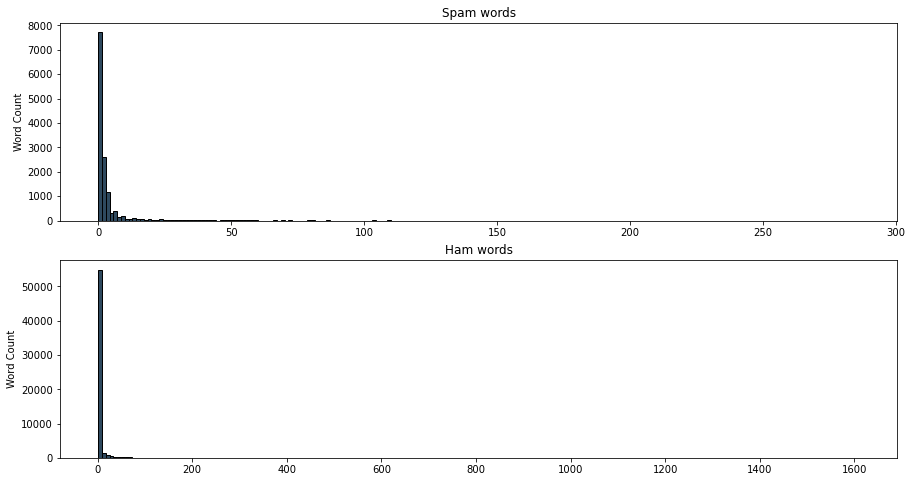

In [13]:
import random
from scratch.machine_learning import split_data

random.seed(0)      # just so you get the same answers as me
train_messages, test_messages = split_data(data, 0.75)
model = NaiveBayesClassifier()

model.train(train_messages,15)
model.token_histogram()

### 3.3 예측 및 성능 평가

#### 예측

In [14]:
from collections import Counter

predictions = [(message, model.predict(message.text))
               for message in test_messages]

#### 혼동 행렬

In [15]:
# Assume that spam_probability > 0.5 corresponds to spam prediction
# and count the combinations of (actual is_spam, predicted is_spam)
confusion_matrix = Counter((message.is_spam, spam_probability > 0.5)
                            for message, spam_probability in predictions)

print(confusion_matrix)



Counter({(False, False): 694, (True, True): 70, (True, False): 60, (False, True): 2})


#### 정확도, 정밀도, 재현율 F1점수 (Q)
혼동 행렬 결과를 이용해서 정확도, 정밀도, 재현율 F1점수를 계산해 보시오. 

In [16]:
from scratch.machine_learning import accuracy, precision, recall, f1_score
tp = confusion_matrix.get((True, True))
tn = confusion_matrix.get((False,False))
fp = confusion_matrix.get((True, False))
fn = confusion_matrix.get((False, True))

print("accuracy :",accuracy(tp,fp,fn,tn))
print("precision :",precision(tp,fp,fn,tn))
print("recall :", recall(tp,fp,fn,tn))
print("f1_score :", f1_score(tp,fp,fn,tn))


accuracy : 0.9249394673123487
precision : 0.5384615384615384
recall : 0.9722222222222222
f1_score : 0.693069306930693


### 3.4 스팸과 햄을 대표하는 단어 확인

In [17]:
def p_spam_given_token(token: str, model: NaiveBayesClassifier) -> float:
    # We probably shouldn't call private methods, but it's for a good cause.
    prob_if_spam, prob_if_ham = model._probabilities(token)

    return prob_if_spam / (prob_if_spam + prob_if_ham)

words = sorted(model.tokens, key=lambda t: p_spam_given_token(t, model))

print("spammiest_words", words[-10:])
print("hammiest_words", words[:10])

spammiest_words ['bordercolordark=', 'transaction.', '111111', 'mailings.', '000066', 'opt-out', '000080', "type='hidden", 'content-languag', 'border-collaps']
hammiest_words ['wrote', 'freshrpms.net', 'rpm-list', '//lists.freshrpms.net/mailman/listinfo/rpm-list', 'aug', 'rpm', 'satalk', 'matthia', 'spamassassin', 'spambay']
